# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Case AME-DIGITAL</p>


This data viz project comes from the fintech AME-Digital's case for Data Engineers. The case itself is based on the Stack Overflow 2018 Developer Survey (available on Kaggle: https://www.kaggle.com/datasets/stackoverflow/stack-overflow-2018-developer-survey). Nearly 100,000 developers took the 30-minute survey in January 2018, answering a total of 129 questions ranging from basic info (gender, age, job title, annual salary estimate) to subjective opinions regarding ethics in coding and responsability towards AI creations.

The case sets specific goals: answering questions regarding average salary of respondents, where they are from, what technologies and communication tools they use etc.

<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤConfig. Settingsㅤ</span>

In [1]:
import platform

print('Version      :', platform.python_version())
print('Compiler     :', platform.python_compiler())
print('Normal       :', platform.platform())

Version      : 3.9.15
Compiler     : MSC v.1929 64 bit (AMD64)
Normal       : Windows-10-10.0.19044-SP0


In [66]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import pycountry # for global plots. 1st time using it, just to compare with tableau!
import random # for random colors!
import plotly.offline as py
from collections import Counter

#for modelling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [6]:
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'SKlearn version: {sklearn.__version__}')

Pandas version: 1.5.2
Numpy version: 1.21.6
Seaborn version: 0.12.1
Matplotlib version: 3.6.2
SKlearn version: 1.0.2


In [7]:
# Display Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤUseful personalized functions for plotsㅤ</span>

In [23]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [24]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [25]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

<a id="3"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Initial Data Inspection</p>

**Importing the datasets**

In [28]:
# Before diving into the dataset let's see what sort of questions were in this survey:
pd.options.display.max_colwidth = 300
schema = pd.read_csv('D:\Ironhack_D\Ironhack\Cases\AME\survey_results_schema.csv')
schema

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree-granting college or university program?"
5,Employment,Which of the following best describes your current employment status?
6,FormalEducation,Which of the following best describes the highest level of formal education that you’ve completed?
7,UndergradMajor,You previously indicated that you went to a college or university. Which of the following best describes your main field of study (aka 'major')
8,CompanySize,Approximately how many people are employed by the company or organization you work for?
9,DevType,Which of the following describe you? Please select all that apply.


In [18]:
data = pd.read_csv('D:\Ironhack_D\Ironhack\Cases\AME\survey_results_public.csv',low_memory=False,sep=',')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98855 entries, 0 to 98854
Columns: 129 entries, Respondent to SurveyEasy
dtypes: float64(41), int64(1), object(87)
memory usage: 97.3+ MB


In [21]:
data #98855 entries

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,3-5 years,Extremely satisfied,Extremely satisfied,Working as a founder or co-founder of my own c...,"I’m not actively looking, but I am open to new...",Less than a year ago,10.0,7.0,8.0,1.0,2.0,5.0,3.0,4.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4.0,2.0,5.0,5.0,6.0,7.0,2.0,1.0,4.0,3.0,My job status or other personal status changed,NaN,NaN,Monthly,NaN,KES,Slack,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,To build my professional network,Strongly agree,Strongly agree,Neither Agree nor Disagree,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Linux-based,1,Agile;Scrum,Git,Multiple times per day,Yes,No,NaN,Strongly agree,Strongly agree,Strongly agree,Saw an online advertisement and then researche...,1.0,5.0,4.0,7.0,2.0,6.0,3.0,Artificial intelligence surpassing human intel...,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,No,"Yes, and publicly",Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,I have never participated in Q&A on Stack Over...,"No, I knew that Stack Overflow had a jobs boar...",Yes,NaN,Yes,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,Standing desk,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,Unite

In [22]:
# Duplicates?
data[data.duplicated()]

# No

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy


In [29]:
# NaNs?
percent = data.isnull().sum()/ len(data) *100
percent.sort_values(ascending = False)

TimeAfterBootcamp              93.270952
MilitaryUS                     84.036215
HackathonReasons               74.011431
ErgonomicDevices               65.547519
AdBlockerReasons               61.817814
StackOverflowJobsRecommend     61.239189
JobEmailPriorities3            53.251732
JobEmailPriorities1            53.251732
JobEmailPriorities2            53.251732
JobEmailPriorities7            53.251732
JobEmailPriorities6            53.251732
JobEmailPriorities5            53.251732
JobEmailPriorities4            53.251732
ConvertedSalary                51.745486
JobContactPriorities4          50.729857
JobContactPriorities5          50.729857
JobContactPriorities3          50.729857
JobContactPriorities1          50.729857
JobContactPriorities2          50.729857
Salary                         48.836174
SalaryType                     48.338476
FrameworkWorkedWith            47.782105
TimeFullyProductive            47.527186
AdBlockerDisable               44.466137
FrameworkDesireN

**Insights**
- No duplicates
- But some columns are massively empty - *Which* does __not__ imply lack of data per se (i.e. not all respondents participated in bootcamps, nor in the military, hence empty values)

Trying a couple of new visualizations:

In [55]:
def random_colors(number_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return color

In [60]:
data1 = data[['Hobby','Age']]
age = data1['Age'].dropna().unique()

label = np.concatenate((np.array(data1['Age'].dropna().unique()), np.array(['Yes','No'])), axis = 0)
data1 = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = random_colors(1),
        width = 0.5
      ),
      label = label,
      color = random_colors(20)
    ),
    link = dict(
      source = [0,1,2,3,4,5,6,0,1,2,3,4,5,6],
      target = [7,7,7,7,7,7,7,8,8,8,8,8,8,8],
      value = [len(data1[(data1['Age'] =='25 - 34 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='35 - 44 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='18 - 24 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='45 - 54 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='55 - 64 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='Under 18 years old') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='65 years or older') & (data1['Hobby'] == 'Yes')])
               ,len(data1[(data1['Age'] =='25 - 34 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='35 - 44 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='18 - 24 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='45 - 54 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='55 - 64 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='Under 18 years old') & (data1['Hobby'] == 'No')])
               ,len(data1[(data1['Age'] =='65 years or older') & (data1['Hobby'] == 'No')])
              ]
  ))


fig = dict(data=[data1])
py.iplot(fig, validate=False)

<!--
• Salário vazio ou com valor “NA” deve ser convertido para zero (0.0).
    # done
• Salário deve ser sempre calculado em reais e mensal. Para esse cálculo você usará a coluna
ConvertedSalary, que contém o salário anual. Considere que 1 dólar equivale a R$3,81.
    # done, but with updated exchange rate of R$5,15
• O nome dos respondentes deve seguir a regra respondente_[número] . (ex: respondente_1,
respondente_2, respondente_3). O critério de geração desse número é todo seu.
• Cada linha da tabela linguagem_programacao deve conter uma única linguagem de
programação.
• Cada linha da tabela ferramenta_comunic deve conter apenas uma ferramenta de
comunicação.
-->

In [6]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].isna().sum() 

# about half of salary information is lost

Currency           36847
Salary             48277
SalaryType         47785
ConvertedSalary    51153
dtype: int64

In [7]:
# convert nans in Salary and Converted Salary to 0.0
data['Salary'] = data['Salary'].fillna(0)
data['ConvertedSalary'] = data['ConvertedSalary'].fillna(0)

In [8]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].isna().sum() # done

Currency           36847
Salary                 0
SalaryType         47785
ConvertedSalary        0
dtype: int64

In [9]:
# ConvertedSalaries must be wrong, as exemplified by
    # data.loc[data['Respondent']=='Respondent_4203'][['Respondent','Currency','Salary','SalaryType','ConvertedSalary','CSMR']]
    # and
    # data.loc[data['Respondent']=='Respondent_1450'][['Respondent','Currency','Salary','SalaryType','ConvertedSalary','CSMR']]

# let's fix the Salary column which is by far the most useful

DATA CLEANING

In [10]:
# ordering Respondent data
data[['Respondent']].reset_index()

,index,Respondent
0,0,1
1,1,3
2,2,4
3,3,5
4,4,7
...,...,...
98850,98850,101513
98851,98851,101531
98852,98852,101541
98853,98853,101544


In [11]:
data['Respondent'] = 'Respondent_' +(data['Respondent'].reset_index()['index'] + 1).astype(str)

In [12]:
# Lets change Yes and No to 1 and 0 respectively
data['OpenSource'] = data['OpenSource'].replace({'No': 0, 'Yes': 1})
data['Hobby'] = data['Hobby'].replace({'No': 0, 'Yes': 1})

In [13]:
# lets pull the useful variables so its easier to work with
df = data[['Respondent','Country','Employment','CompanySize','OperatingSystem','DevType','YearsCoding',
'LanguageWorkedWith','CommunicationTools','ConvertedSalary','Gender','Age','Exercise','OpenSource','Hobby']]

print(df.shape)

(98855, 15)


In [14]:
df['testdev'] = pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True)

C:\Users\hbati\AppData\Local\Temp\ipykernel_3744\1451380126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['testdev'] = pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True)


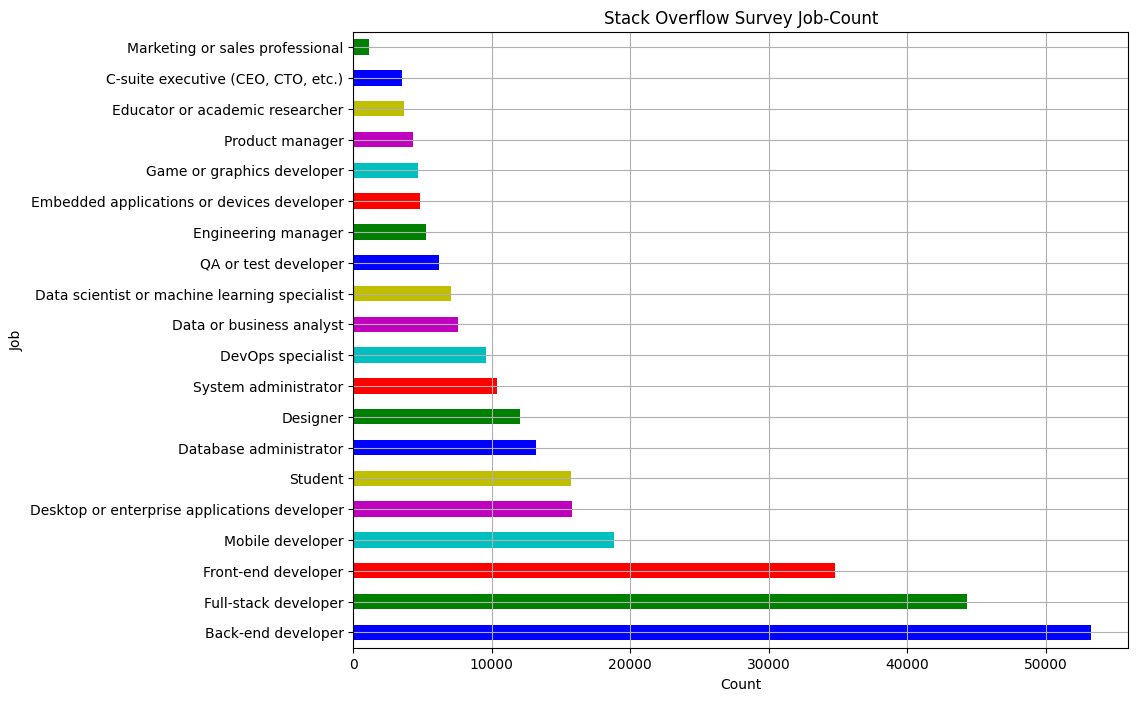

In [15]:
df_jobs = pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True).value_counts()
c = ['b', 'g', 'r', 'c', 'm','y']

# Create plot
df_jobs.plot(kind='barh', figsize=(10,8),color = c)
plt.title('Stack Overflow Survey Job-Count')
plt.xlabel('Count')
plt.ylabel('Job')
plt.grid()
plt.show()

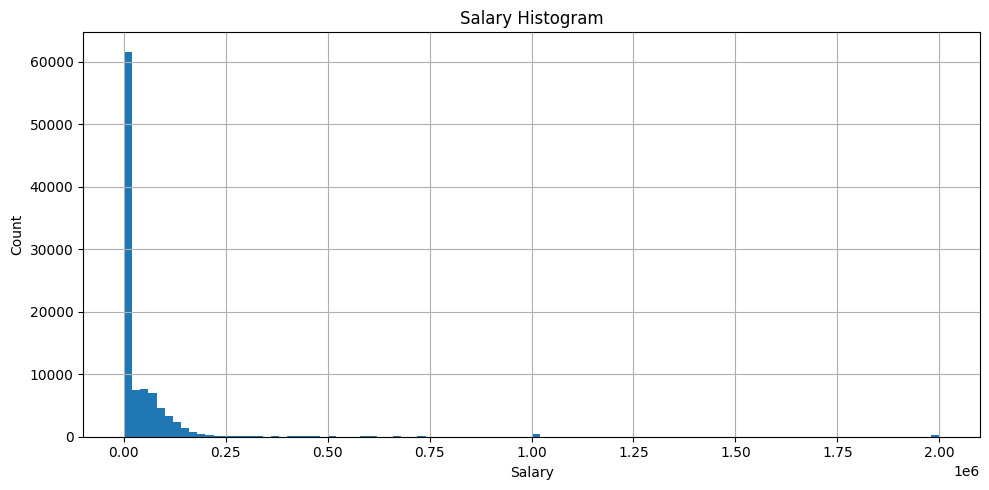

In [16]:
# Create subplots
fig, axarr = plt.subplots(figsize=(10,5))

# Create histogram
df['ConvertedSalary'].hist(bins=100, ax=axarr)
axarr.set_title('Salary Histogram')
axarr.set_xlabel('Salary')
axarr.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [17]:
# Remove the zeroes, and these outliers need to go. I'll cut anyone who makes more than half a million per year, that's just ridiculous.
# Actually only keep people who make >3000 USD/year. That should amount to those that get at least a minimum wage and we won't lose that many people
df = df[(df['ConvertedSalary']>3000) & (df['ConvertedSalary']<500000)]

In [18]:
df.shape # yeah ok that's not so bad

(44083, 16)

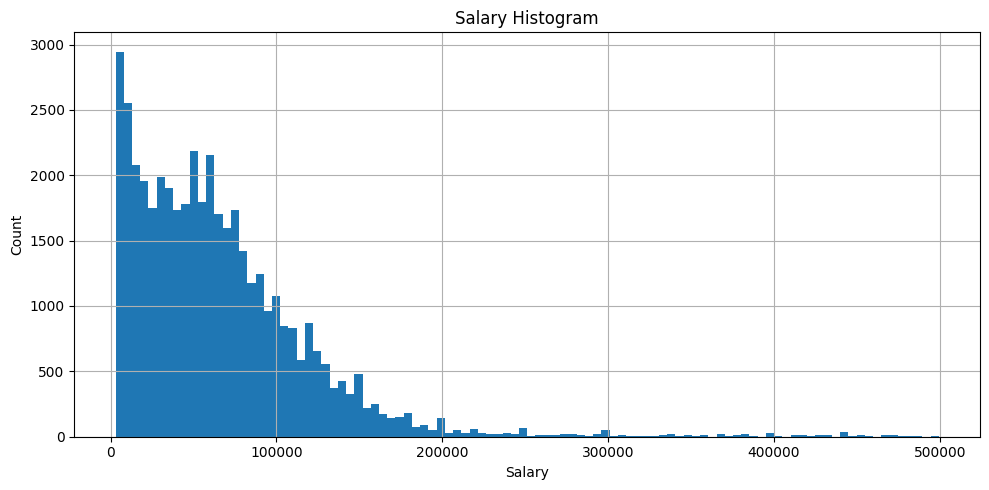

In [19]:
# Create subplots
fig, axarr = plt.subplots(figsize=(10,5))

# Create histogram
df['ConvertedSalary'].hist(bins=100, ax=axarr)
axarr.set_title('Salary Histogram')
axarr.set_xlabel('Salary')
axarr.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [20]:
df['Country'].value_counts()[0:20]

United States         12206
India                  3468
United Kingdom         3425
Germany                3152
Canada                 1868
France                 1339
Russian Federation     1164
Australia              1096
Brazil                 1062
Netherlands             938
Spain                   920
Poland                  910
Italy                   700
Sweden                  651
Switzerland             516
Israel                  432
Ukraine                 411
Austria                 381
Turkey                  366
Belgium                 361
Name: Country, dtype: int64

In [21]:
df['Country'].value_counts()[0:49]

United States                   12206
India                            3468
United Kingdom                   3425
Germany                          3152
Canada                           1868
France                           1339
Russian Federation               1164
Australia                        1096
Brazil                           1062
Netherlands                       938
Spain                             920
Poland                            910
Italy                             700
Sweden                            651
Switzerland                       516
Israel                            432
Ukraine                           411
Austria                           381
Turkey                            366
Belgium                           361
Czech Republic                    354
Denmark                           347
South Africa                      342
Romania                           328
Mexico                            322
Pakistan                          310
Norway      

In [22]:
data['Country'].value_counts()[0:49]

United States                   20309
India                           13721
Germany                          6459
United Kingdom                   6221
Canada                           3393
Russian Federation               2869
France                           2572
Brazil                           2505
Poland                           2122
Australia                        2018
Netherlands                      1841
Spain                            1769
Italy                            1535
Ukraine                          1279
Sweden                           1164
Pakistan                         1050
China                            1037
Switzerland                      1010
Turkey                           1004
Israel                           1003
Iran, Islamic Republic of...      921
Romania                           793
Austria                           788
Czech Republic                    784
Belgium                           743
Mexico                            736
Bangladesh  

In [23]:
#I will only keep the first 49 countries, as they have more than 100 respondents each.
df_country = df['Country'].value_counts().head(49)

In [24]:
df = df[df['Country'].isin(df_country.index)]

In [25]:
df.shape # yeah ok that's not so bad

(41817, 16)

In [26]:
# For Gender, I might wanna keep only Males and Females.
df[df['Gender'].isin(['Male', 'Female'])].shape

(38636, 16)

In [27]:
df = df[df['Gender'].isin(['Male', 'Female'])]
#df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

In [28]:
# 0s and 1s too
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

In [29]:
df.shape # yeah ok that's not so bad

(38636, 16)

In [30]:
#Age
df['Age'].isna().sum()

209

In [31]:
df['Age'].value_counts()

25 - 34 years old     20821
35 - 44 years old      7696
18 - 24 years old      7187
45 - 54 years old      2055
55 - 64 years old       515
Under 18 years old       96
65 years or older        57
Name: Age, dtype: int64

In [32]:
# maybe we should reorder this and reindex..
age = ['Under 18 years old',
       '18 - 24 years old',
       '25 - 34 years old',
       '35 - 44 years old',
       '45 - 54 years old',
       '55 - 64 years old',
       '65 years or older']

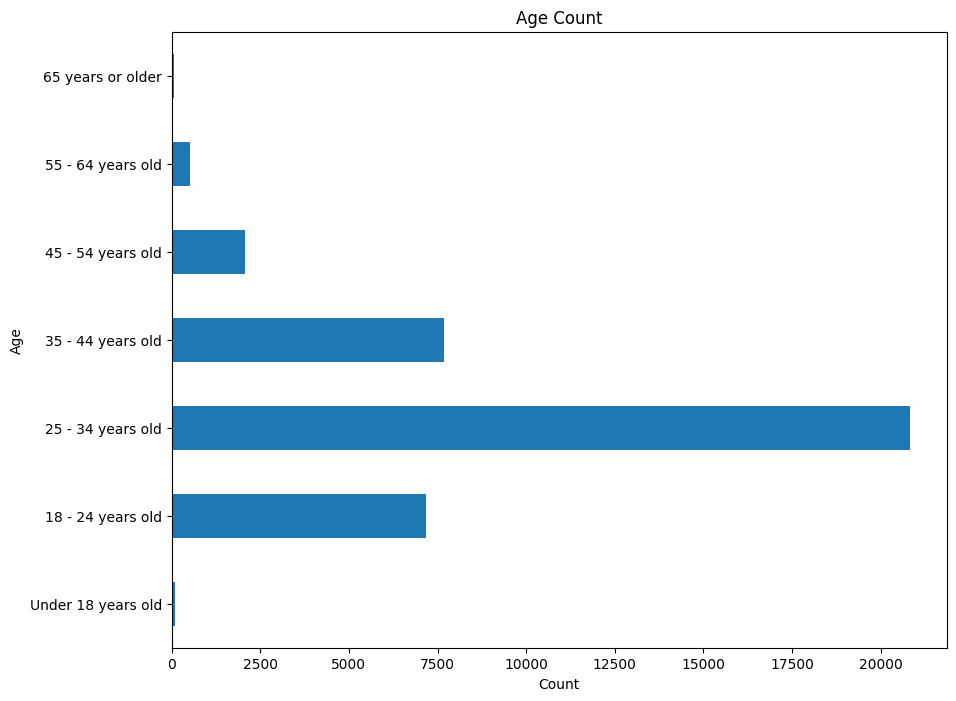

In [33]:
# Create plot
df['Age'].value_counts().reindex(age).plot(kind='barh', figsize=(10,8))
plt.title('Age Count')
plt.xlabel('Count')
plt.ylabel('Age')
plt.show()

In [34]:
#ConvertedSalary: Salary converted to annual USD salaries using the exchange rate on 2018-01-18, assuming 12 working months and 50 working weeks

In [35]:
data[data['Salary'].str.contains(',') == True]['Salary'] # There might be some confusion between ',' and '.' depending on currency? Let's explore..

833         2688,82
1449       35000,00
2365      2,000,000
2506        7080,65
2939     112,000.00
            ...    
87785     35,000.00
87841    500,000.00
87868        455,00
89246      1,500.00
89374      3,000.00
Name: Salary, Length: 251, dtype: object

In [36]:
data['Currency'].value_counts()

U.S. dollars ($)               20601
Euros (€)                      15201
Indian rupees (₹)               7908
British pounds sterling (£)     4856
Canadian dollars (C$)           2535
Russian rubles (₽)              1768
Brazilian reais (R$)            1663
Australian dollars (A$)         1571
Polish złoty (zł)               1434
Swedish kroner (SEK)             864
Swiss francs                     671
Chinese yuan renminbi (¥)        512
Danish krone (kr)                461
Mexican pesos (MXN$)             457
South African rands (R)          432
Norwegian krone (kr)             423
Singapore dollars (S$)           263
Japanese yen (¥)                 241
Bitcoin (btc)                    147
Name: Currency, dtype: int64

In [37]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].iloc[87841] #how is this conversion made if currency is NaN?

Currency                  NaN
Salary             500,000.00
SalaryType            Monthly
ConvertedSalary         444.0
Name: 87841, dtype: object

In [38]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].iloc[87868] #checks out, monthly euros to yearly dollars

Currency           Euros (€)
Salary                455,00
SalaryType           Monthly
ConvertedSalary     668232.0
Name: 87868, dtype: object

In [39]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].iloc[178]

Currency           U.S. dollars ($)
Salary                       125000
SalaryType                   Yearly
ConvertedSalary            125000.0
Name: 178, dtype: object

In [40]:
# bottomline, let's stick with ConvertedSalary which standardizes Salary.

In [41]:
data['SalaryType'].value_counts()

Monthly    26252
Yearly     22556
Weekly      2262
Name: SalaryType, dtype: int64

In [42]:
data[['Currency','Salary','SalaryType','ConvertedSalary']].head(20)
#ConvertedSalary: Salary converted to annual USD salaries using the exchange rate on 2018-01-18, assuming 12 working months and 50 working weeks

,Currency,Salary,SalaryType,ConvertedSalary
0,NaN,0,Monthly,0.0
1,British pounds sterling (£),51000,Yearly,70841.0
2,NaN,0,NaN,0.0
3,U.S. dollars ($),0,NaN,0.0
4,South African rands (R),260000,Yearly,21426.0
5,British pounds sterling (£),30000,NaN,41671.0
6,U.S. dollars ($),120000,Yearly,120000.0
7,NaN,0,NaN,0.0
8,U.S. dollars ($),250000,Yearly,250000.0
9,NaN,0,NaN,0.0


In [43]:
#let's add a column where ConvertedSalary is converted to monthly reais

In [44]:
df.head() # this is the final dataset that I will use to train the model, lets split them here

,Respondent,Country,Employment,CompanySize,OperatingSystem,DevType,YearsCoding,LanguageWorkedWith,CommunicationTools,ConvertedSalary,Gender,Age,Exercise,OpenSource,Hobby,testdev
1,Respondent_2,United Kingdom,Employed full-time,"10,000 or more employees",Linux-based,Database administrator;DevOps specialist;Full-...,30 or more years,JavaScript;Python;Bash/Shell,Confluence;Office / productivity suite (Micros...,70841.0,0,35 - 44 years old,Daily or almost every day,1,1,Database administrator
4,Respondent_5,South Africa,Employed full-time,"10,000 or more employees",Windows,Data or business analyst;Desktop or enterprise...,6-8 years,C;C++;Java;Matlab;R;SQL;Bash/Shell,"Office / productivity suite (Microsoft Office,...",21426.0,0,18 - 24 years old,3 - 4 times per week,0,1,System administrator
5,Respondent_6,United Kingdom,Employed full-time,10 to 19 employees,Linux-based,Back-end developer;Database administrator;Fron...,6-8 years,Java;JavaScript;Python;TypeScript;HTML;CSS,Confluence;Jira;Office / productivity suite (M...,41671.0,0,18 - 24 years old,1 - 2 times per week,0,1,Engineering manager
6,Respondent_7,United States,Employed full-time,"10,000 or more employees",MacOS,Back-end developer;Front-end developer;Full-st...,9-11 years,JavaScript;HTML;CSS,Confluence;Office / productivity suite (Micros...,120000.0,0,18 - 24 years old,I don't typically exercise,1,1,Full-stack developer
8,Respondent_9,United States,Employed full-time,100 to 499 employees,MacOS,"Back-end developer;C-suite executive (CEO, CTO...",30 or more years,Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,Confluence;HipChat;Jira;Office / productivity ...,250000.0,0,35 - 44 years old,I don't typically exercise,1,1,Data or business analyst


In [45]:
df_model = df

In [46]:
#'CSMR' stands for ConvertedSalaryMonthlyReais
data['CSMR'] = (data['ConvertedSalary']/12)*3.2058621479276392

In [47]:
data[['Currency','Salary','SalaryType','ConvertedSalary','CSMR']].head(30)

,Currency,Salary,SalaryType,ConvertedSalary,CSMR
0,NaN,0,Monthly,0.0,0.000000
1,British pounds sterling (£),51000,Yearly,70841.0,18925.540035
2,NaN,0,NaN,0.0,0.000000
3,U.S. dollars ($),0,NaN,0.0,0.000000
4,South African rands (R),260000,Yearly,21426.0,5724.066865
5,British pounds sterling (£),30000,NaN,41671.0,11132.623464
6,U.S. dollars ($),120000,Yearly,120000.0,32058.621479
7,NaN,0,NaN,0.0,0.000000
8,U.S. dollars ($),250000,Yearly,250000.0,66788.794748
9,NaN,0,NaN,0.0,0.000000


In [48]:
# ConvertedSalary might be standardized, but it's definitely not clean, e.g.
data.iloc[22][['Currency','Salary','SalaryType','ConvertedSalary','CSMR']]

Currency           British pounds sterling (£)
Salary                                      25
SalaryType                             Monthly
ConvertedSalary                          420.0
CSMR                                112.205175
Name: 22, dtype: object

In [49]:
# The conversion to yearly dollars checks out, but the salary value itself has to be wrong. We might want to establish mininum values.
# This should become clearer once we plot the data.

In [50]:
#Convert column 'Respondent' (with randomized IDs) to sequential Respondent_1, Respondent_2 and so forth

In [51]:
data.loc[data['Respondent']=='Respondent_323'][['Respondent','Currency','Salary','SalaryType','ConvertedSalary','CSMR']]

,Respondent,Currency,Salary,SalaryType,ConvertedSalary,CSMR
322,Respondent_323,Brazilian reais (R$),50000,Monthly,187152.0,49998.626059


In [52]:
data.loc[data['Respondent']=='Respondent_410'][['Respondent','Currency','Salary','SalaryType','ConvertedSalary','CSMR']]

,Respondent,Currency,Salary,SalaryType,ConvertedSalary,CSMR
409,Respondent_410,Brazilian reais (R$),14000,Monthly,52404.0,14000.0


In [53]:
#anual em reais
14000*12 # = 168000

#anual em USD
168000 * 0.26246719160104987 # = 44094.48818897638 ta diferente com essa taxa de conversao

44094.48818897638

In [54]:
168000/52404.0 # = 3.2058621479276392, que deve ser a taxa de conversão da época

3.2058621479276392

In [55]:
data.loc[data['Respondent']=='Respondent_4203'][['Respondent','Currency','Salary','SalaryType','ConvertedSalary','CSMR']]

#hmmmmmmmmmmm! commas to dots

,Respondent,Currency,Salary,SalaryType,ConvertedSalary,CSMR
4202,Respondent_4203,Brazilian reais (R$),"3190,00",Monthly,1000000.0,267155.178994


In [56]:
#new column for Student
data['StudentYN'] = data['Student']

In [57]:
data['StudentYN'] = data['StudentYN'].replace({'No': 0, 'Yes, full-time': 1})

In [58]:
data['StudentYN'] = data['StudentYN'].replace({'Yes, part-time': 1})

In [59]:
data['Student'].value_counts()

No                70399
Yes, full-time    18394
Yes, part-time     6108
Name: Student, dtype: int64

In [60]:
data['StudentYN'].value_counts() #done

0.0    70399
1.0    24502
Name: StudentYN, dtype: int64

Now organizing the SQL tables

In [61]:
#linguagem_programacao:
data['LanguageWorkedWith']

0                              JavaScript;Python;HTML;CSS
1                            JavaScript;Python;Bash/Shell
2                                                     NaN
3        C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell
4                      C;C++;Java;Matlab;R;SQL;Bash/Shell
                               ...                       
98850                                                 NaN
98851                                                 NaN
98852                                                 NaN
98853                                                 NaN
98854                                                 NaN
Name: LanguageWorkedWith, Length: 98855, dtype: object

In [62]:
data['LanguageWorkedWith'] = data['LanguageWorkedWith'].str.split(';')

In [63]:
data['LanguageWorkedWith']

0                          [JavaScript, Python, HTML, CSS]
1                         [JavaScript, Python, Bash/Shell]
2                                                      NaN
3        [C#, JavaScript, SQL, TypeScript, HTML, CSS, B...
4               [C, C++, Java, Matlab, R, SQL, Bash/Shell]
                               ...                        
98850                                                  NaN
98851                                                  NaN
98852                                                  NaN
98853                                                  NaN
98854                                                  NaN
Name: LanguageWorkedWith, Length: 98855, dtype: object

In [64]:
languages = data[['Respondent','LanguageWorkedWith']].explode('LanguageWorkedWith')

In [65]:
languages

,Respondent,LanguageWorkedWith
0,Respondent_1,JavaScript
0,Respondent_1,Python
0,Respondent_1,HTML
0,Respondent_1,CSS
1,Respondent_2,JavaScript
...,...,...
98850,Respondent_98851,NaN
98851,Respondent_98852,NaN
98852,Respondent_98853,NaN
98853,Respondent_98854,NaN


In [66]:
# Ferramentas Comunicação

In [67]:
data['CommunicationTools'] = data['CommunicationTools'].str.split(';')

In [68]:
data['CommunicationTools'][1]

['Confluence',
 'Office / productivity suite (Microsoft Office, Google Suite, etc.)',
 'Slack',
 'Other wiki tool (Github, Google Sites, proprietary software, etc.)']

In [69]:
tools = data[['Respondent','CommunicationTools']].explode('CommunicationTools')

In [70]:
tools

,Respondent,CommunicationTools
0,Respondent_1,Slack
1,Respondent_2,Confluence
1,Respondent_2,"Office / productivity suite (Microsoft Office,..."
1,Respondent_2,Slack
1,Respondent_2,"Other wiki tool (Github, Google Sites, proprie..."
...,...,...
98850,Respondent_98851,NaN
98851,Respondent_98852,NaN
98852,Respondent_98853,NaN
98853,Respondent_98854,NaN


Plotting

In [71]:
data.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy,CSMR,StudentYN
0,Respondent_1,1,0,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy,0.000000,0.0
1,Respondent_2,1,1,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy,18925.540035,0.0
2,Respondent_3,1,1,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
3,Respondent_4,0,0,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy,0.000000,0.0
4,Respondent_5,1,0,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy,5724.066865,1.0


we need to create some new tables for SQL to ingest:

In [72]:
#Countries table

Country = pd.DataFrame(data['Country'].unique(),columns=['Country'])
Country

#data['Country'].isna().sum() yields 412 nulls

,Country
0,Kenya
1,United Kingdom
2,United States
3,South Africa
4,Nigeria
...,...
179,Eritrea
180,Democratic People's Republic of Korea
181,Djibouti
182,NaN


In [73]:
Country.sort_values(by='Country',inplace=True)
Country

,Country
78,Afghanistan
85,Albania
27,Algeria
150,Andorra
108,Angola
...,...
45,Viet Nam
100,Yemen
160,Zambia
119,Zimbabwe


In [74]:
Country.reset_index(drop=True,inplace=True)
Country

,Country
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
...,...
179,Viet Nam
180,Yemen
181,Zambia
182,Zimbabwe


In [75]:
Country.reset_index(inplace=True)

In [76]:
Country

,index,Country
0,0,Afghanistan
1,1,Albania
2,2,Algeria
3,3,Andorra
4,4,Angola
...,...,...
179,179,Viet Nam
180,180,Yemen
181,181,Zambia
182,182,Zimbabwe


In [77]:
Country = Country.rename(columns = {'index':'Country_id'}) #Done!
Country

,Country_id,Country
0,0,Afghanistan
1,1,Albania
2,2,Algeria
3,3,Andorra
4,4,Angola
...,...,...
179,179,Viet Nam
180,180,Yemen
181,181,Zambia
182,182,Zimbabwe


In [78]:
#Companies table
Companies= pd.DataFrame(data['CompanySize'].unique(),columns=['CompanySize'])
Companies

# data['CompanySize'].isna().sum() yields 27324 values.. I'll keep them

,CompanySize
0,20 to 99 employees
1,"10,000 or more employees"
2,100 to 499 employees
3,10 to 19 employees
4,500 to 999 employees
5,"1,000 to 4,999 employees"
6,"5,000 to 9,999 employees"
7,Fewer than 10 employees
8,NaN


In [79]:
Companies = Companies.reindex([7,3,0,2,4,5,6,1,8])
Companies 

,CompanySize
7,Fewer than 10 employees
3,10 to 19 employees
0,20 to 99 employees
2,100 to 499 employees
4,500 to 999 employees
5,"1,000 to 4,999 employees"
6,"5,000 to 9,999 employees"
1,"10,000 or more employees"
8,NaN


In [80]:
Companies = Companies.reset_index(drop=True)
Companies

,CompanySize
0,Fewer than 10 employees
1,10 to 19 employees
2,20 to 99 employees
3,100 to 499 employees
4,500 to 999 employees
5,"1,000 to 4,999 employees"
6,"5,000 to 9,999 employees"
7,"10,000 or more employees"
8,NaN


In [81]:
Companies = Companies.reset_index()
Companies

,index,CompanySize
0,0,Fewer than 10 employees
1,1,10 to 19 employees
2,2,20 to 99 employees
3,3,100 to 499 employees
4,4,500 to 999 employees
5,5,"1,000 to 4,999 employees"
6,6,"5,000 to 9,999 employees"
7,7,"10,000 or more employees"
8,8,NaN


In [82]:
Companies = Companies.rename(columns = {'index':'Company_id'}) #Done!
Companies

,Company_id,CompanySize
0,0,Fewer than 10 employees
1,1,10 to 19 employees
2,2,20 to 99 employees
3,3,100 to 499 employees
4,4,500 to 999 employees
5,5,"1,000 to 4,999 employees"
6,6,"5,000 to 9,999 employees"
7,7,"10,000 or more employees"
8,8,NaN


In [83]:
# Now for OperatingSystem

OS = pd.DataFrame(data['OperatingSystem'].unique(),columns=['OperatingSystem'])
OS

# data['OperatingSystem'].isna().sum() yields 22676 nulls.. maybe I will keep it

,OperatingSystem
0,Linux-based
1,NaN
2,Windows
3,MacOS
4,BSD/Unix


In [84]:
OS = OS.reindex([2,3,0,4,1])
OS

,OperatingSystem
2,Windows
3,MacOS
0,Linux-based
4,BSD/Unix
1,NaN


In [85]:
OS = OS.reset_index(drop=True)
OS

,OperatingSystem
0,Windows
1,MacOS
2,Linux-based
3,BSD/Unix
4,NaN


In [86]:
OS = OS.reset_index().rename(columns = {'index':'OS_id'}) #Done!
OS

,OS_id,OperatingSystem
0,0,Windows
1,1,MacOS
2,2,Linux-based
3,3,BSD/Unix
4,4,NaN


In [87]:
OS

,OS_id,OperatingSystem
0,0,Windows
1,1,MacOS
2,2,Linux-based
3,3,BSD/Unix
4,4,NaN


In [88]:
# Now for Resp_use_language
language = pd.DataFrame(languages['LanguageWorkedWith'].unique(),columns=['LanguageWorkedWith'])
language.head(10) #puts como que eu faço pra jogar o nan pro final?

,LanguageWorkedWith
0,JavaScript
1,Python
2,HTML
3,CSS
4,Bash/Shell
5,NaN
6,C#
7,SQL
8,TypeScript
9,C


In [89]:
language = language.reset_index()
language = language.rename(columns = {'index':'Language_id'})

language # done! Now to create a table with respondent and language_id

,Language_id,LanguageWorkedWith
0,0,JavaScript
1,1,Python
2,2,HTML
3,3,CSS
4,4,Bash/Shell
5,5,NaN
6,6,C#
7,7,SQL
8,8,TypeScript
9,9,C


In [90]:
languages

,Respondent,LanguageWorkedWith
0,Respondent_1,JavaScript
0,Respondent_1,Python
0,Respondent_1,HTML
0,Respondent_1,CSS
1,Respondent_2,JavaScript
...,...,...
98850,Respondent_98851,NaN
98851,Respondent_98852,NaN
98852,Respondent_98853,NaN
98853,Respondent_98854,NaN


In [91]:
# Now for Resp_usa_linguagem
resp_usa_linguagem = pd.merge(left=languages,right=language,how='left').drop(columns='LanguageWorkedWith')

In [92]:
resp_usa_linguagem #done!

,Respondent,Language_id
0,Respondent_1,0
1,Respondent_1,1
2,Respondent_1,2
3,Respondent_1,3
4,Respondent_2,0
...,...,...
506184,Respondent_98851,5
506185,Respondent_98852,5
506186,Respondent_98853,5
506187,Respondent_98854,5


In [93]:
# Now for Resp_usa_ferramenta
tools

,Respondent,CommunicationTools
0,Respondent_1,Slack
1,Respondent_2,Confluence
1,Respondent_2,"Office / productivity suite (Microsoft Office,..."
1,Respondent_2,Slack
1,Respondent_2,"Other wiki tool (Github, Google Sites, proprie..."
...,...,...
98850,Respondent_98851,NaN
98851,Respondent_98852,NaN
98852,Respondent_98853,NaN
98853,Respondent_98854,NaN


In [94]:
tool = pd.DataFrame(tools['CommunicationTools'].unique(),columns=['CommunicationTools'])

In [95]:
tool = tool.reset_index()
tool = tool.rename(columns = {'index':'Tool_id'})


In [96]:
tool #Done!

,Tool_id,CommunicationTools
0,0,Slack
1,1,Confluence
2,2,"Office / productivity suite (Microsoft Office,..."
3,3,"Other wiki tool (Github, Google Sites, proprie..."
4,4,NaN
5,5,Jira
6,6,"Other chat system (IRC, proprietary software, ..."
7,7,Stack Overflow Enterprise
8,8,Facebook
9,9,Google Hangouts/Chat


In [97]:
tools

,Respondent,CommunicationTools
0,Respondent_1,Slack
1,Respondent_2,Confluence
1,Respondent_2,"Office / productivity suite (Microsoft Office,..."
1,Respondent_2,Slack
1,Respondent_2,"Other wiki tool (Github, Google Sites, proprie..."
...,...,...
98850,Respondent_98851,NaN
98851,Respondent_98852,NaN
98852,Respondent_98853,NaN
98853,Respondent_98854,NaN


In [98]:
resp_usa_ferramenta = pd.merge(left=tools,right=tool,how='left').drop(columns='CommunicationTools')

In [99]:
resp_usa_ferramenta

,Respondent,Tool_id
0,Respondent_1,0
1,Respondent_2,1
2,Respondent_2,2
3,Respondent_2,0
4,Respondent_2,3
...,...,...
198208,Respondent_98851,4
198209,Respondent_98852,4
198210,Respondent_98853,4
198211,Respondent_98854,4


In [100]:
# Now for ferramenta_comunic
ferramenta_comunic = tool

In [101]:
# Now for linguagem_programacao
linguagem_programacao = language

In [102]:
# Now for Respondent

In [103]:
Respondent_pre = data[['Respondent','OpenSource','Hobby','CSMR','ConvertedSalary','OperatingSystem','Country','CompanySize']]
Respondent_pre

,Respondent,OpenSource,Hobby,CSMR,ConvertedSalary,OperatingSystem,Country,CompanySize
0,Respondent_1,0,1,0.000000,0.0,Linux-based,Kenya,20 to 99 employees
1,Respondent_2,1,1,18925.540035,70841.0,Linux-based,United Kingdom,"10,000 or more employees"
2,Respondent_3,1,1,0.000000,0.0,NaN,United States,20 to 99 employees
3,Respondent_4,0,0,0.000000,0.0,Windows,United States,100 to 499 employees
4,Respondent_5,0,1,5724.066865,21426.0,Windows,South Africa,"10,000 or more employees"
...,...,...,...,...,...,...,...,...
98850,Respondent_98851,1,1,0.000000,0.0,NaN,United States,NaN
98851,Respondent_98852,1,0,0.000000,0.0,NaN,Spain,NaN
98852,Respondent_98853,1,1,0.000000,0.0,NaN,India,NaN
98853,Respondent_98854,0,1,0.000000,0.0,NaN,Russian Federation,NaN


In [104]:
Respondente = pd.merge(left=Respondent_pre,right=OS,how='left') #merged OS
Respondente = pd.merge(left=Respondente,right=Companies,how='left') #merged Companies
Respondente = pd.merge(left=Respondente,right=Country,how='left') #merged Country
Respondente = Respondente.drop(columns=['OperatingSystem','Country','CompanySize'])

Organizing all the tables I need to transfer to MySQL

In [105]:
#sistema_operacional:
OS
#país:
Country
#empresa:
Companies
#linguagem:
language
#ferramenta_comunic:
tool
#resp_usa_ferramenta:
resp_usa_ferramenta
#resp_usa_linguagem:
resp_usa_linguagem
#respondente:
Respondente

,Respondent,OpenSource,Hobby,CSMR,ConvertedSalary,OS_id,Company_id,Country_id
0,Respondent_1,0,1,0.000000,0.0,2,2,85
1,Respondent_2,1,1,18925.540035,70841.0,2,7,173
2,Respondent_3,1,1,0.000000,0.0,4,2,175
3,Respondent_4,0,0,0.000000,0.0,0,3,175
4,Respondent_5,0,1,5724.066865,21426.0,0,7,150
...,...,...,...,...,...,...,...,...
98850,Respondent_98851,1,1,0.000000,0.0,4,8,175
98851,Respondent_98852,1,0,0.000000,0.0,4,8,152
98852,Respondent_98853,1,1,0.000000,0.0,4,8,74
98853,Respondent_98854,0,1,0.000000,0.0,4,8,137


In [106]:
OS.to_csv('OS.csv')

In [107]:
Country.to_csv('Country.csv')

In [108]:
Companies.to_csv('Companies.csv')

In [109]:
language.to_csv('language.csv')

In [110]:
tool.to_csv('tool.csv')

In [111]:
resp_usa_ferramenta.to_csv('resp_usa_ferramenta.csv')

In [112]:
resp_usa_linguagem.to_csv('resp_usa_linguagem.csv')

In [113]:
Respondente.to_csv('Respondente')

In [114]:
pip install pymysql

Note: you may need to restart the kernel to use updated packages.


In [115]:
# import sqlalchemy as db

# db_server='pymysql'
# user='root'
# db_port = '3306'
# password = 'password'
# ip = '127.0.0.1'
# db_name = 'ame' # schema do sql check
# engine = db.create_engine(f'mysql+{db_server}://{user}:{password}@{ip}:{db_port}/{db_name}?charset=utf8')
# conn = engine.connect()


In [116]:
# OS.to_sql('os', conn, if_exists='replace', index=False)


In [117]:
# Country.to_sql('country', conn, if_exists='replace', index=False)

In [118]:
# Companies.to_sql('companies', conn, if_exists='replace', index=False)

In [119]:
# language.to_sql('language', conn, if_exists='replace', index=False)

In [120]:
# tool.to_sql('tool', conn, if_exists='replace', index=False)

In [121]:
# resp_usa_ferramenta.to_sql('resp_usa_ferramenta', conn, if_exists='replace', index=False)

In [122]:
# resp_usa_linguagem.to_sql('resp_usa_linguagem', conn, if_exists='replace', index=False)

In [123]:
# Respondente.to_sql('respondente', conn, if_exists='replace', index=False)

Model for Salary Estimate

In [124]:
# Data distribution: as seen from the plot, seems to taper down in logarithmic fashion. How about we convert?
np.log(df_model['ConvertedSalary'].values) #oh, needs to be .values, careful

array([11.16819321,  9.97236042, 10.63756072, ..., 10.15766455,
       11.48486544,  9.23834457])

In [125]:
# Creating labels: y
y = np.log(df_model['ConvertedSalary'].values)

In [126]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38636 entries, 1 to 89954
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Respondent          38636 non-null  object 
 1   Country             38636 non-null  object 
 2   Employment          38562 non-null  object 
 3   CompanySize         34122 non-null  object 
 4   OperatingSystem     38471 non-null  object 
 5   DevType             38366 non-null  object 
 6   YearsCoding         38625 non-null  object 
 7   LanguageWorkedWith  38513 non-null  object 
 8   CommunicationTools  35541 non-null  object 
 9   ConvertedSalary     38636 non-null  float64
 10  Gender              38636 non-null  int64  
 11  Age                 38427 non-null  object 
 12  Exercise            38493 non-null  object 
 13  OpenSource          38636 non-null  int64  
 14  Hobby               38636 non-null  int64  
 15  testdev             38636 non-null  object 
dtypes: f

In [127]:
df_model2 = df_model.drop(['Respondent','DevType','OperatingSystem','LanguageWorkedWith'], axis=1)
df_model2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38636 entries, 1 to 89954
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             38636 non-null  object 
 1   Employment          38562 non-null  object 
 2   CompanySize         34122 non-null  object 
 3   YearsCoding         38625 non-null  object 
 4   CommunicationTools  35541 non-null  object 
 5   ConvertedSalary     38636 non-null  float64
 6   Gender              38636 non-null  int64  
 7   Age                 38427 non-null  object 
 8   Exercise            38493 non-null  object 
 9   OpenSource          38636 non-null  int64  
 10  Hobby               38636 non-null  int64  
 11  testdev             38636 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 3.8+ MB


In [128]:
df_model2['Employment'].unique()

array(['Employed full-time', 'Employed part-time',
       'Independent contractor, freelancer, or self-employed', nan,
       'Not employed, but looking for work',
       'Not employed, and not looking for work', 'Retired'], dtype=object)

In [129]:
#lets fix for employeds only
employment = ['Employed full-time', 
              'Employed part-time', 
              'Independent contractor, freelancer, or self-employed']
df_model2 = df_model2[df_model2['Employment'].fillna('Employed full-time').isin(employment)]

In [130]:
# X should be populated with data from df_model, with the exception of ConvertedSalary obviously. How about get_dummies?
# X = pd.get_dummies(df_model2).values

In [131]:
# df_model2['Age'].value_counts()

In [132]:
# Now to split in training and testing datasets

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1) #for training
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.25, random_state=1) #for testing

In [133]:
# print(f'Training examples:\t\t{X_train.shape[0]}\nExamples for optimization loss:\t{X_valid.shape[0]}\nFinal testing examples:\t\t{X_test.shape[0]}')

In [134]:
#wait a second, pycaret!

In [135]:
from pycaret.regression import *

In [136]:
# df_model2

In [137]:
df_model2.head()

,Country,Employment,CompanySize,YearsCoding,CommunicationTools,ConvertedSalary,Gender,Age,Exercise,OpenSource,Hobby,testdev
1,United Kingdom,Employed full-time,"10,000 or more employees",30 or more years,Confluence;Office / productivity suite (Micros...,70841.0,0,35 - 44 years old,Daily or almost every day,1,1,Database administrator
4,South Africa,Employed full-time,"10,000 or more employees",6-8 years,"Office / productivity suite (Microsoft Office,...",21426.0,0,18 - 24 years old,3 - 4 times per week,0,1,System administrator
5,United Kingdom,Employed full-time,10 to 19 employees,6-8 years,Confluence;Jira;Office / productivity suite (M...,41671.0,0,18 - 24 years old,1 - 2 times per week,0,1,Engineering manager
6,United States,Employed full-time,"10,000 or more employees",9-11 years,Confluence;Office / productivity suite (Micros...,120000.0,0,18 - 24 years old,I don't typically exercise,1,1,Full-stack developer
8,United States,Employed full-time,100 to 499 employees,30 or more years,Confluence;HipChat;Jira;Office / productivity ...,250000.0,0,35 - 44 years old,I don't typically exercise,1,1,Data or business analyst


In [138]:
df_model2['Age'].unique()

array(['35 - 44 years old', '18 - 24 years old', '25 - 34 years old',
       '45 - 54 years old', '55 - 64 years old', nan,
       'Under 18 years old', '65 years or older'], dtype=object)

In [139]:
df_model2['Age'] = df_model2['Age'].replace(to_replace={'Under 18 years old' : 1,'18 - 24 years old' : 2,'25 - 34 years old' : 3,'35 - 44 years old' : 4,'45 - 54 years old' : 5,'55 - 64 years old' : 6,'65 years or older' : 7})

In [140]:
df_model2['YearsCoding'].unique() #= df_model2['Age'].replace(to_replace={'Under 18 years old' : 1,'18 - 24 years old' : 2,'25 - 34 years old' : 3,'35 - 44 years old' : 4,'45 - 54 years old' : 5,'55 - 64 years old' : 6,'65 years or older' : 7})

array(['30 or more years', '6-8 years', '9-11 years', '15-17 years',
       '12-14 years', '3-5 years', '0-2 years', '24-26 years',
       '18-20 years', '21-23 years', '27-29 years', nan], dtype=object)

In [141]:
df_model2['YearsCoding'] = df_model2['YearsCoding'].replace(to_replace={'0-2 years' : 1,'3-5 years' : 2,'6-8 years' : 3,'9-11 years' : 4, '12-14 years' : 5, '15-17 years' : 6,'18-20 years' : 7,
'21-23 years' : 8, '24-26 years' : 9, '27-29 years' : 10, '30 or more years' : 11})

In [142]:
df_model2['CompanySize'].unique()

array(['10,000 or more employees', '10 to 19 employees',
       '100 to 499 employees', '1,000 to 4,999 employees',
       '20 to 99 employees', '500 to 999 employees',
       '5,000 to 9,999 employees', 'Fewer than 10 employees', nan],
      dtype=object)

In [143]:
df_model2['CompanySize'] = df_model2['CompanySize'].replace(to_replace={'Fewer than 10 employees' : 1,'10 to 19 employees' : 2,'20 to 99 employees' : 3,'100 to 499 employees' : 4, '500 to 999 employees' : 5,
'1,000 to 4,999 employees' : 6,'5,000 to 9,999 employees' : 7, '10,000 or more employees' : 8})

In [144]:
df_model2['Exercise'].unique()

array(['Daily or almost every day', '3 - 4 times per week',
       '1 - 2 times per week', "I don't typically exercise", nan],
      dtype=object)

In [145]:
df_model2['Exercise'] = df_model2['Exercise'].replace(to_replace={'Daily or almost every day' : 1,'3 - 4 times per week' : 2,'1 - 2 times per week' : 3,"I don't typically exercise" : 4})

In [146]:
#maybe only with US data..
df_model_usa = df_model2.loc[df_model2['Country'] == 'United States']
df_model_usa .shape

(11173, 12)

In [147]:
df_model_usa.head()

,Country,Employment,CompanySize,YearsCoding,CommunicationTools,ConvertedSalary,Gender,Age,Exercise,OpenSource,Hobby,testdev
6,United States,Employed full-time,8.0,4.0,Confluence;Office / productivity suite (Micros...,120000.0,0,2.0,4.0,1,1,Full-stack developer
8,United States,Employed full-time,4.0,11.0,Confluence;HipChat;Jira;Office / productivity ...,250000.0,0,4.0,4.0,1,1,Data or business analyst
32,United States,Employed full-time,5.0,3.0,"Office / productivity suite (Microsoft Office,...",44000.0,1,2.0,1.0,0,1,Back-end developer
33,United States,Employed full-time,6.0,2.0,"Office / productivity suite (Microsoft Office,...",60000.0,1,3.0,4.0,0,0,Database administrator
35,United States,Employed full-time,3.0,5.0,Google Hangouts/Chat;Slack;Other chat system (...,80000.0,0,3.0,1.0,1,1,System administrator


In [150]:
df_model2.head()

,Country,Employment,CompanySize,YearsCoding,CommunicationTools,ConvertedSalary,Gender,Age,Exercise,OpenSource,Hobby,testdev
1,United Kingdom,Employed full-time,8.0,11.0,Confluence;Office / productivity suite (Micros...,70841.0,0,4.0,1.0,1,1,Database administrator
4,South Africa,Employed full-time,8.0,3.0,"Office / productivity suite (Microsoft Office,...",21426.0,0,2.0,2.0,0,1,System administrator
5,United Kingdom,Employed full-time,2.0,3.0,Confluence;Jira;Office / productivity suite (M...,41671.0,0,2.0,3.0,0,1,Engineering manager
6,United States,Employed full-time,8.0,4.0,Confluence;Office / productivity suite (Micros...,120000.0,0,2.0,4.0,1,1,Full-stack developer
8,United States,Employed full-time,4.0,11.0,Confluence;HipChat;Jira;Office / productivity ...,250000.0,0,4.0,4.0,1,1,Data or business analyst


In [151]:
a = setup(df_model2,target='ConvertedSalary',normalize=True,remove_outliers=True,numeric_features = ['Gender','Hobby','Age','YearsCoding','CompanySize','Exercise','OpenSource'],transformation=True,transform_target=True)

,Description,Value
0,session_id,7054
1,Target,ConvertedSalary
2,Original Data,"(37826, 12)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(25154, 399)"


In [ ]:
# best_model = compare_models()

IntProgress(value=0, description='Processing: ', max=94)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:35:55
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,22035.6017,1928447027.6951,43798.9918,0.3741,0.5351,0.4350,0.9770
ridge,Ridge Regression,22087.2086,1932062246.4000,43841.1270,0.3729,0.5359,0.4347,0.3000
omp,Orthogonal Matching Pursuit,22397.1544,1948488841.7572,44028.5126,0.3675,0.5463,0.4513,0.3100
huber,Huber Regressor,21731.9788,1957392597.6812,44124.3727,0.3647,0.5344,0.4007,5.5390
knn,K Neighbors Regressor,27411.3230,2226945288.1016,47092.9641,0.2762,0.6724,0.6885,4.2600
lasso,Lasso Regression,38176.8910,3251761075.2000,56970.0535,-0.0600,0.9162,1.2550,0.0670
en,Elastic Net,38176.8910,3251761075.2000,56970.0535,-0.0600,0.9162,1.2550,0.0760
llar,Lasso Least Angle Regression,38176.8918,3251761045.6807,56970.0532,-0.0600,0.9162,1.2550,0.8860
dt,Decision Tree Regressor,30037.4248,3246870883.0594,56936.2145,-0.0603,0.7040,0.6504,0.3920
lr,Linear Regression,37988.8379,6323266836083.2002,834455.1590,-2009.6926,0.5398,0.6830,0.2650


In [ ]:
# Accuracy: (TN+TP)/all
# Precision: TP  / (TP + FP), foca a importancia do falso positivo (erro tipo II)
# Recall: TP / (TP + FN), foca a importancia do falso negativo (erro tipo I): falei que nao vai chover e choveu, seu burro
# F1: media harmonica do recall e precisao, procura um equilibrio entre as duas metricas. 

In [152]:
model = create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23961.3040,2552636833.0751,50523.6265,0.2821,0.5829,0.5032
1,23105.3984,1759436374.9093,41945.6359,0.3865,0.5779,0.5299
2,23781.3194,2091153103.3406,45729.1275,0.3341,0.5820,0.5080
3,24048.5425,2316055478.5723,48125.4141,0.3168,0.5817,0.5216
4,23267.3812,1968107678.5665,44363.3596,0.3551,0.5855,0.5351
5,24017.2744,2150348186.4263,46371.8469,0.3271,0.5799,0.5013
6,24606.8535,2242392574.4340,47353.9077,0.3148,0.5837,0.4957
7,24207.8424,2292622456.9630,47881.3373,0.3005,0.5854,0.5074
8,23430.0111,1962127144.0126,44295.9044,0.3498,0.5456,0.4764


In [153]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

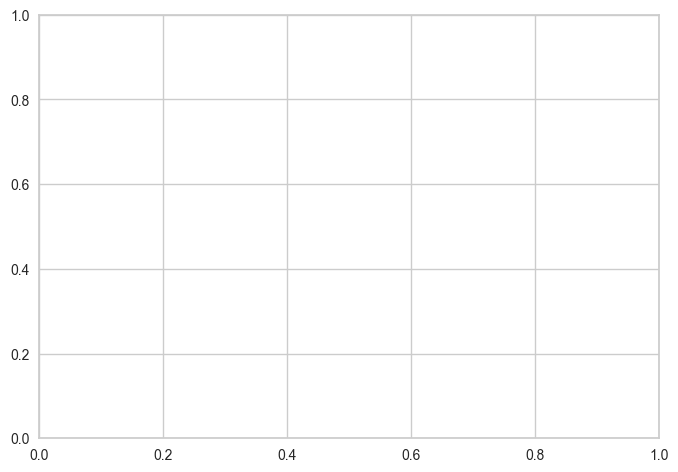

ValueError: Plot Not Available. Please see docstring for list of available Plots.

In [ ]:
plot_model(model,plot='confusion_matrix')

In [ ]:
df_model.to_csv('datamod.csv')

In [ ]:
df_model2.to_csv('df_model2.csv')

In [ ]:
pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True).value_counts()

Back-end developer                               23562
Full-stack developer                             20805
Front-end developer                              14816
Desktop or enterprise applications developer      7243
Mobile developer                                  7177
Database administrator                            5656
DevOps specialist                                 5124
System administrator                              4555
Designer                                          4211
Data or business analyst                          3247
Data scientist or machine learning specialist     3056
Student                                           3052
QA or test developer                              2930
Engineering manager                               2466
Embedded applications or devices developer        2203
Product manager                                   1847
Game or graphics developer                        1371
Educator or academic researcher                   1318
C-suite ex

In [ ]:
pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True)

0           Database administrator
1                DevOps specialist
2             Full-stack developer
3             System administrator
4         Data or business analyst
                    ...           
116272                     Student
116273                     Student
116274                     Student
116275                     Student
116276                     Student
Length: 116277, dtype: object